In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

In [ ]:
# Suppress TensorFlow warnings and set memory growth
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load and preprocess the Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnant', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

In [ ]:
# Split features and labels
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [ ]:
# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
# Split into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Further split training data into 20 parts for 20 MIoT devices
num_devices = 20
train_size = len(X_train)
device_data_size = train_size // num_devices
X_train_devices = [X_train[i:i+device_data_size] for i in range(0, train_size, device_data_size)]
y_train_devices = [y_train[i:i+device_data_size] for i in range(0, train_size, device_data_size)]


In [ ]:
# Split training data into train and validation for each device
X_train_dev, X_val_dev, y_train_dev, y_val_dev = [], [], [], []
for i in range(num_devices):
    X_t, X_v, y_t, y_v = train_test_split(X_train_devices[i], y_train_devices[i], test_size=0.2, random_state=42)
    X_train_dev.append(X_t)
    X_val_dev.append(X_v)
    y_train_dev.append(y_t)
    y_val_dev.append(y_v)


In [ ]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(8,)),  # Explicit Input layer
        layers.Reshape((8, 1, 1)),
        layers.Conv2D(32, (3, 1), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 1), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Original Federated Learning
def original_fl(num_rounds=30, batch_size=64, local_epochs=5):
    global_model = create_model()
    train_accuracies, val_accuracies, test_accuracies, losses = [], [], [], []
    local_models = [create_model() for _ in range(num_devices)]  # Reuse models

    for round in range(num_rounds):
        try:
            global_weights = global_model.get_weights()
            client_weights = []

            # Local training on each device
            for i in range(num_devices):
                local_models[i].set_weights(global_weights)
                local_models[i].fit(X_train_dev[i], y_train_dev[i], batch_size=batch_size,
                                   epochs=local_epochs, verbose=0)
                client_weights.append(local_models[i].get_weights())

            # Aggregate weights
            global_weights = [np.mean([client_weights[j][k] for j in range(num_devices)], axis=0)
                             for k in range(len(global_weights))]
            global_model.set_weights(global_weights)

            # Evaluate
            train_loss, train_acc = 0, 0
            val_loss, val_acc = 0, 0
            for i in range(num_devices):
                t_loss, t_acc = global_model.evaluate(X_train_dev[i], y_train_dev[i], verbose=0)
                v_loss, v_acc = global_model.evaluate(X_val_dev[i], y_val_dev[i], verbose=0)
                train_loss += t_loss / num_devices
                train_acc += t_acc / num_devices
                val_loss += v_loss / num_devices
                val_acc += v_acc / num_devices

            test_loss, test_acc = global_model.evaluate(X_test, y_test, verbose=0)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            test_accuracies.append(test_acc)
            losses.append(train_loss)
            print(f"Round {round+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {train_loss:.4f}")

            # Clear memory
            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"Error in round {round+1}: {str(e)}")
            break

    return train_accuracies, val_accuracies, test_accuracies, losses, global_model

In [ ]:
# BlockFL (Simplified Blockchain-based FL)
def blockfl(num_rounds=30, batch_size=64, local_epochs=5):
    global_model = create_model()
    train_accuracies, val_accuracies, test_accuracies, losses = [], [], [], []
    local_models = [create_model() for _ in range(num_devices)]  # Reuse models

    for round in range(num_rounds):
        try:
            global_weights = global_model.get_weights()
            client_weights = []
            client_gradients = []

            # Local training on each device
            for i in range(num_devices):
                local_models[i].set_weights(global_weights)
                local_models[i].fit(X_train_dev[i], y_train_dev[i], batch_size=batch_size,
                                   epochs=local_epochs, verbose=0)
                weights_before = global_weights
                weights_after = local_models[i].get_weights()
                gradients = [w_a - w_b for w_a, w_b in zip(weights_after, weights_before)]
                client_gradients.append(gradients)
                client_weights.append(weights_after)

            # Simplified consensus: select top gradients
            gradient_norms = [np.mean([np.linalg.norm(g) for g in grads]) for grads in client_gradients]
            num_byzantine = int(0.1 * num_devices)
            top_indices = np.argsort(gradient_norms)[:num_devices - num_byzantine]
            selected_weights = [client_weights[i] for i in top_indices]

            # Aggregate weights
            global_weights = [np.mean([selected_weights[j][k] for j in range(len(selected_weights))], axis=0)
                             for k in range(len(global_weights))]
            global_model.set_weights(global_weights)

            # Evaluate
            train_loss, train_acc = 0, 0
            val_loss, val_acc = 0, 0
            for i in range(num_devices):
                t_loss, t_acc = global_model.evaluate(X_train_dev[i], y_train_dev[i], verbose=0)
                v_loss, v_acc = global_model.evaluate(X_val_dev[i], y_val_dev[i], verbose=0)
                train_loss += t_loss / num_devices
                train_acc += t_acc / num_devices
                val_loss += v_loss / num_devices
                val_acc += v_acc / num_devices

            test_loss, test_acc = global_model.evaluate(X_test, y_test, verbose=0)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            test_accuracies.append(test_acc)
            losses.append(train_loss)
            print(f"Round {round+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {train_loss:.4f}")

            # Clear memory
            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"Error in round {round+1}: {str(e)}")
            break

    return train_accuracies, val_accuracies, test_accuracies, losses, global_model

In [ ]:
# Run experiments
num_rounds = 40
print("Running Original FL...")
fl_metrics = original_fl(num_rounds, batch_size=64, local_epochs=5)
print("\nRunning BlockFL...")
blockfl_metrics = blockfl(num_rounds, batch_size=64, local_epochs=5)

Running Original FL...
Round 1: Train Acc: 0.7025, Val Acc: 0.5667, Test Acc: 0.6580, Loss: 0.6119
Round 2: Train Acc: 0.7125, Val Acc: 0.5667, Test Acc: 0.6710, Loss: 0.5502
Round 3: Train Acc: 0.7675, Val Acc: 0.6167, Test Acc: 0.6883, Loss: 0.4930
Round 4: Train Acc: 0.7950, Val Acc: 0.6500, Test Acc: 0.7749, Loss: 0.4439
Round 5: Train Acc: 0.8125, Val Acc: 0.6500, Test Acc: 0.7662, Loss: 0.4206
Round 6: Train Acc: 0.8150, Val Acc: 0.6500, Test Acc: 0.7662, Loss: 0.4119
Round 7: Train Acc: 0.8125, Val Acc: 0.6583, Test Acc: 0.7619, Loss: 0.4065
Round 8: Train Acc: 0.8150, Val Acc: 0.6667, Test Acc: 0.7706, Loss: 0.4013
Round 9: Train Acc: 0.8200, Val Acc: 0.6667, Test Acc: 0.7619, Loss: 0.3965
Round 10: Train Acc: 0.8225, Val Acc: 0.6833, Test Acc: 0.7489, Loss: 0.3925
Round 11: Train Acc: 0.8225, Val Acc: 0.6750, Test Acc: 0.7489, Loss: 0.3890
Round 12: Train Acc: 0.8250, Val Acc: 0.6750, Test Acc: 0.7446, Loss: 0.3862
Round 13: Train Acc: 0.8225, Val Acc: 0.6917, Test Acc: 0.7403

In [ ]:
# Plotting function (fixed unpacking)
def plot_results(fl_metrics, blockfl_metrics, X_test, y_test, fl_model, blockfl_model):
    fl_train_acc, fl_val_acc, fl_test_acc, fl_losses, _ = fl_metrics  # Unpack 5 elements, ignore model
    blockfl_train_acc, blockfl_val_acc, blockfl_test_acc, blockfl_losses, _ = blockfl_metrics  # Unpack 5 elements, ignore model

    plt.figure(figsize=(12, 8))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(fl_train_acc, label='Original FL Train Acc', color='#1f77b4')
    plt.plot(fl_val_acc, label='Original FL Val Acc', color='#ff7f0e')
    plt.plot(fl_test_acc, label='Original FL Test Acc', color='#2ca02c')
    plt.plot(blockfl_train_acc, label='BlockFL Train Acc', linestyle='--', color='#1f77b4')
    plt.plot(blockfl_val_acc, label='BlockFL Val Acc', linestyle='--', color='#ff7f0e')
    plt.plot(blockfl_test_acc, label='BlockFL Test Acc', linestyle='--', color='#2ca02c')
    plt.title('Accuracy over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(fl_losses, label='Original FL Loss', color='#1f77b4')
    plt.plot(blockfl_losses, label='BlockFL Loss', linestyle='--', color='#ff7f0e')
    plt.title('Loss over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()

    # Confusion Matrix
    y_pred_fl = (fl_model.predict(X_test) > 0.5).astype(int).flatten()
    y_pred_blockfl = (blockfl_model.predict(X_test) > 0.5).astype(int).flatten()

    plt.subplot(2, 2, 3)
    cm_fl = confusion_matrix(y_test, y_pred_fl)
    sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Blues')
    plt.title('Original FL Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(2, 2, 4)
    cm_blockfl = confusion_matrix(y_test, y_pred_blockfl)
    sns.heatmap(cm_blockfl, annot=True, fmt='d', cmap='Blues')
    plt.title('BlockFL Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.savefig('fl_blockfl_metrics_plot.png')
    plt.close()

    # ROC Curve
    fpr_fl, tpr_fl, _ = roc_curve(y_test, fl_model.predict(X_test))
    fpr_blockfl, tpr_blockfl, _ = roc_curve(y_test, blockfl_model.predict(X_test))
    roc_auc_fl = auc(fpr_fl, tpr_fl)
    roc_auc_blockfl = auc(fpr_blockfl, tpr_blockfl)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_fl, tpr_fl, label=f'Original FL (AUC = {roc_auc_fl:.2f})', color='#1f77b4')
    plt.plot(fpr_blockfl, tpr_blockfl, label=f'BlockFL (AUC = {roc_auc_blockfl:.2f})', linestyle='--', color='#ff7f0e')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('roc_curve_plot.png')
    plt.close()
# Plot results even if partial
plot_results(fl_metrics, blockfl_metrics, X_test, y_test, fl_metrics[4], blockfl_metrics[4])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Displaying: fl_blockfl_metrics_plot.png


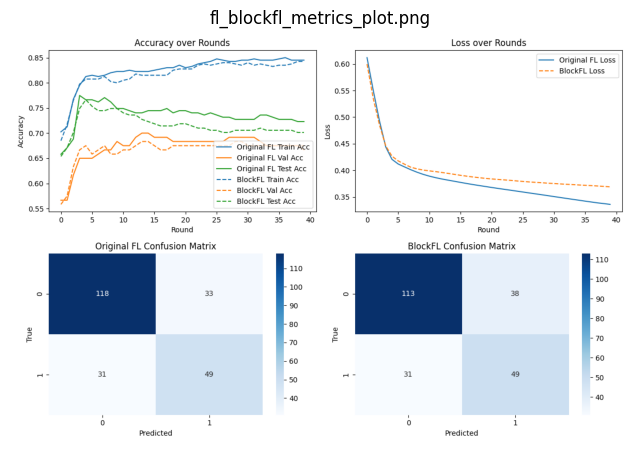

Displaying: roc_curve_plot.png


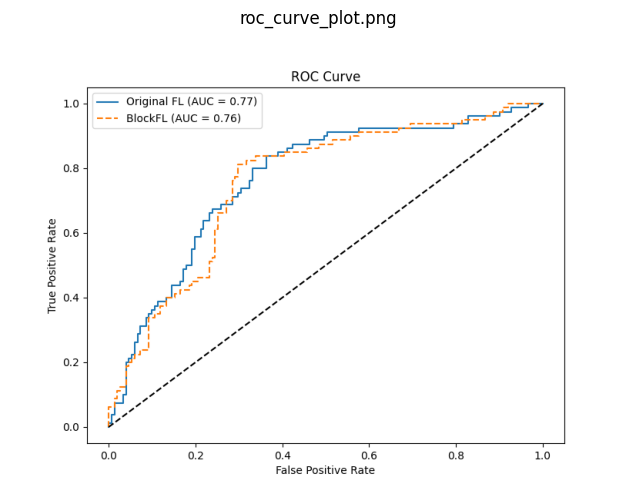

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_plots(dataset='pima'):
    # Define models and methods
    metrics = ['fl_blockfl_metrics', 'roc_curve']  # Adjust metrics based on your code
    plotst = 'plot'

    # Directory where plots are saved
    plot_dir = '/content'  # Update if plots are saved elsewhere (e.g., './plots/')

    # Loop through all combinations
    for metric in metrics:
        # Construct plot filename based on your naming convention
        plot_file = f"{metric}_{plotst}.png"
        plot_path = os.path.join(plot_dir, plot_file)

        # Check if the plot exists
        if os.path.exists(plot_path):
            print(f"Displaying: {plot_file}")
            # Load and display the image
            img = Image.open(plot_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(plot_file)
            plt.show()
        else:
            print(f"Plot not found: {plot_file}")

# Call the function to display MNIST plots
display_plots(dataset='pima')